In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torch.optim as optim

In [14]:
###to add
### bias, tensorboard, validation set

In [15]:
device = torch.device('cpu')

In [16]:
device

device(type='cpu')

In [17]:
#tensorboard 
tbwriter = SummaryWriter()

In [18]:
dataset = datasets.ImageFolder("./data/caltech101/101_ObjectCategories/", transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Resize((227,227))
    ]))  
        # input size should be : (b x 3 x 227 x 227)
        # The image in the original paper states that width and height are 224 pixels, but
        # the dimensions after first convolution layer do not lead to 55 x 55.

train, test = torch.utils.data.random_split(dataset,[7000,2144])


train_ds = torch.utils.data.DataLoader(train, batch_size=4,
                                          shuffle=True)



In [19]:
classes = []
labels = dataset.class_to_idx
for i in labels:
    classes.append(i) 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Motorbikes  lamp Motorbikes cougar_face


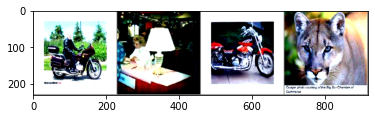

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_ds)
images, label = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[label[j]] for j in range(4)))


In [21]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels= 3, out_channels=96, kernel_size = (11,11), stride= 4) #(b, 96, 55, 55)
        self.norm = nn.LocalResponseNorm(5, k=2, alpha=0.00004, beta=0.75) #k = 2, n = 5, α = 10−4, and β = 0.75.
        self.pool = nn.MaxPool2d(3,2) #(b, 96, 27, 27)
        self.dropout = nn.Dropout2d(0.5)
        self.conv2 = nn.Conv2d(96, 256, 5)  #(b, 256, 23, 23)
        self.conv3 = nn.Conv2d(256, 384, 3) 
        self.conv4 = nn.Conv2d(384, 384, 3)  
        self.conv5 = nn.Conv2d(384, 256, 3) 
        self.fc1 = nn.Linear(256 * 2 * 2, 4096) 
        self.fc2 = nn.Linear(4096,4096)
        self.fc3 = nn.Linear(4096,102)

    def forward(self,x):
        x = self.pool(self.norm(F.relu(self.conv1(x)))) #(b, 96, 55, 55) after max pooling #(b, 96, 27, 27)
        x = self.pool(self.norm(F.relu(self.conv2(x)))) #(b, 256, 23, 23) after max pooling #(b, 256, 11, 11)

        x = F.relu(self.conv3(x)) # (b, 384, 9, 9)

        x = F.relu(self.conv4(x)) # (b, 384, 7, 7)

        x = self.pool(F.relu(self.conv5(x))) #(b, 256, 2, 2)

        x = x.view(-1, 256 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x) 
        return x
    

net = Net().to(device)

In [22]:
initial_lr = 0.01
momentum = 0.9
weight_decay = 0.0005

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=initial_lr)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)


In [23]:
num_epochs = 1
total_steps = 1
for epoch in range(num_epochs):
    num =+ 1
    print(num)
    running_loss = 0
    lr_scheduler.step()
    for i, data in enumerate(train_ds, 0):
        img, label = data
       # print(img.shape, label.shape)
        
        img, label = img.to(device), label.to(device)
        
        #calculate loss
        output = net(img)
        #output = model(img)
        #print(output.shape)
        loss = loss_function(output,label)
        
        # update parameters
        optimizer.zero_grad() # zeres the gradient
        loss.backward() #calculates the gradient
        optimizer.step()
        
        #running_loss += loss.item()
        
        
        if total_steps % 10 == 0:
            with torch.no_grad():
                _, preds = torch.max(output, 1)
                accuracy = torch.sum(preds == label)

                print('Epoch: {} \tStep: {} \tLoss: {:.4f} \tAcc: {}'
                    .format(epoch + 1, total_steps, loss.item(), accuracy.item()))
                tbwriter.add_scalar('loss', loss.item(), total_steps)
                tbwriter.add_scalar('accuracy', accuracy.item(), total_steps)

            # print out gradient values and parameter average values
        if total_steps % 100 == 0:
            with torch.no_grad():
                # print and save the grad of the parameters
                # also print and save parameter values
                print('*' * 10)
                for name, parameter in net.named_parameters():
                    if parameter.grad is not None:
                        avg_grad = torch.mean(parameter.grad)
                        print('\t{} - grad_avg: {}'.format(name, avg_grad))
                        tbwriter.add_scalar('grad_avg/{}'.format(name), avg_grad.item(), total_steps)
                        tbwriter.add_histogram('grad/{}'.format(name),
                                parameter.grad.cpu().numpy(), total_steps)
                    if parameter.data is not None:
                        avg_weight = torch.mean(parameter.data)
                        print('\t{} - param_avg: {}'.format(name, avg_weight))
                        tbwriter.add_histogram('weight/{}'.format(name),
                                parameter.data.cpu().numpy(), total_steps)
                        tbwriter.add_scalar('weight_avg/{}'.format(name), avg_weight.item(), total_steps)

        total_steps += 1

        
        


print('Finished Training')
        
        
        

1
Epoch: 1 	Step: 10 	Loss: 4.6097 	Acc: 0
Epoch: 1 	Step: 20 	Loss: 4.6259 	Acc: 0
Epoch: 1 	Step: 30 	Loss: 4.6270 	Acc: 0
Epoch: 1 	Step: 40 	Loss: 4.6240 	Acc: 0
Epoch: 1 	Step: 50 	Loss: 4.6106 	Acc: 0
Epoch: 1 	Step: 60 	Loss: 4.6217 	Acc: 0
Epoch: 1 	Step: 70 	Loss: 4.6100 	Acc: 0
Epoch: 1 	Step: 80 	Loss: 4.5899 	Acc: 1
Epoch: 1 	Step: 90 	Loss: 4.6093 	Acc: 0
Epoch: 1 	Step: 100 	Loss: 4.6184 	Acc: 0
**********
	conv1.weight - grad_avg: -1.1519904546730686e-05
	conv1.weight - param_avg: -5.6698088883422315e-05
	conv1.bias - grad_avg: -6.2723265727981925e-06
	conv1.bias - param_avg: -0.00514013459905982
	conv2.weight - grad_avg: -3.3380274544470012e-06
	conv2.weight - param_avg: 1.7574870071257465e-05
	conv2.bias - grad_avg: -5.165093170944601e-06
	conv2.bias - param_avg: 0.0012194503797218204
	conv3.weight - grad_avg: -1.0373272516517318e-06
	conv3.weight - param_avg: -5.4236797950579785e-06
	conv3.bias - grad_avg: -1.9524304661899805e-06
	conv3.bias - param_avg: 0.00139381096

Epoch: 1 	Step: 500 	Loss: 5.5072 	Acc: 0
**********
	conv1.weight - grad_avg: 0.0030977807473391294
	conv1.weight - param_avg: -0.00021181468036957085
	conv1.bias - grad_avg: 0.015169193036854267
	conv1.bias - param_avg: -0.004717822652310133
	conv2.weight - grad_avg: 0.004612133838236332
	conv2.weight - param_avg: 6.692788156215101e-05
	conv2.bias - grad_avg: 0.009817065671086311
	conv2.bias - param_avg: 0.0015958156436681747
	conv3.weight - grad_avg: 0.0022091930732131004
	conv3.weight - param_avg: 4.875713784713298e-05
	conv3.bias - grad_avg: 0.0101448530331254
	conv3.bias - param_avg: 0.0020548789761960506
	conv4.weight - grad_avg: 0.0013109679566696286
	conv4.weight - param_avg: 3.550488327164203e-05
	conv4.bias - grad_avg: 0.008623931556940079
	conv4.bias - param_avg: 0.0008566579781472683
	conv5.weight - grad_avg: 0.0015408488688990474
	conv5.weight - param_avg: 4.0779399569146335e-05
	conv5.bias - grad_avg: 0.010029257275164127
	conv5.bias - param_avg: 0.002284744754433632
	fc

	conv3.bias - grad_avg: -0.00093621457926929
	conv3.bias - param_avg: 0.0027769592124968767
	conv4.weight - grad_avg: -6.0763755755033344e-05
	conv4.weight - param_avg: 4.250416168360971e-05
	conv4.bias - grad_avg: -0.0007908751722425222
	conv4.bias - param_avg: 0.0018892422085627913
	conv5.weight - grad_avg: -7.157627260312438e-05
	conv5.weight - param_avg: 5.1014147175010294e-05
	conv5.bias - grad_avg: -0.0009997482411563396
	conv5.bias - param_avg: 0.003939374350011349
	fc1.weight - grad_avg: -1.4785332496103365e-05
	fc1.weight - param_avg: 3.7047811929369345e-07
	fc1.bias - grad_avg: -0.00013535218022298068
	fc1.bias - param_avg: 0.0005146826151758432
	fc2.weight - grad_avg: -1.2427090950950515e-05
	fc2.weight - param_avg: 5.386938482843107e-06
	fc2.bias - grad_avg: -0.00021145604841876775
	fc2.bias - param_avg: 0.0008707813103683293
	fc3.weight - grad_avg: 1.8261227599514207e-11
	fc3.weight - param_avg: -6.940184903214686e-06
	fc3.bias - grad_avg: 8.765388970211063e-10
	fc3.bias -

	fc1.bias - grad_avg: 0.001062931027263403
	fc1.bias - param_avg: 0.0007229772745631635
	fc2.weight - grad_avg: 2.9537637601606548e-05
	fc2.weight - param_avg: 7.0735304689151235e-06
	fc2.bias - grad_avg: 0.0011468601878732443
	fc2.bias - param_avg: 0.001163193490356207
	fc3.weight - grad_avg: -2.054388083261305e-11
	fc3.weight - param_avg: -6.9401612563524395e-06
	fc3.bias - grad_avg: -8.765388970211063e-10
	fc3.bias - param_avg: -0.00013112773012835532
Epoch: 1 	Step: 1310 	Loss: 4.0766 	Acc: 0
Epoch: 1 	Step: 1320 	Loss: 2.7401 	Acc: 1
Epoch: 1 	Step: 1330 	Loss: 4.2760 	Acc: 0
Epoch: 1 	Step: 1340 	Loss: 4.2343 	Acc: 0
Epoch: 1 	Step: 1350 	Loss: 4.3026 	Acc: 1
Epoch: 1 	Step: 1360 	Loss: 4.3881 	Acc: 0
Epoch: 1 	Step: 1370 	Loss: 4.4504 	Acc: 0
Epoch: 1 	Step: 1380 	Loss: 4.1450 	Acc: 1
Epoch: 1 	Step: 1390 	Loss: 2.9147 	Acc: 1
Epoch: 1 	Step: 1400 	Loss: 5.1984 	Acc: 0
**********
	conv1.weight - grad_avg: 0.004547432065010071
	conv1.weight - param_avg: 2.361064252909273e-05
	con

Epoch: 1 	Step: 1710 	Loss: 3.6035 	Acc: 0
Epoch: 1 	Step: 1720 	Loss: 3.8167 	Acc: 0
Epoch: 1 	Step: 1730 	Loss: 3.7087 	Acc: 0
Epoch: 1 	Step: 1740 	Loss: 4.3969 	Acc: 0
Epoch: 1 	Step: 1750 	Loss: 3.8484 	Acc: 0
Finished Training


In [24]:
import torch

In [25]:
torch.__version__

'1.13.0.dev20220825'